## Problem statement

For the top 10 users (with more checkins) build: (Refer to section 4)
- A basket of recommendation: venues (places)
- A list of likely venues (places) the user will visit based on their friends.
- Where they will go next (with probability scores).

For the top 10 more “social” users (with more friends): (Refer to section 5)
- Draw the path (with map) of a week/month of users checkins.
- List your friends and how close they are in terms of “taste” (based on venues visited and ranked)

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import implicit

## Open database connection

In [2]:
conn = sqlite3.connect('fsdata.db')
print("Database opened successfully")

Database opened successfully


# 1. Perform data munging

Noticed in social graph there are users which are not registered in users table, and not having bi-direction relationship. Could be due to no foreign key constraint enabled on that SQLite table.

Following is to clean up these records.

## Clean socialgraph table from invalid user id, to contain only bi-direction network

In [3]:
sql = "DELETE FROM socialgraph WHERE first_user_id not in (select id from users)"
sql += " or second_user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on socialgraph which doesn't exists in users table deleted successfully")

Record on socialgraph which doesn't exists in users table deleted successfully


In [4]:
sql = "DELETE FROM socialgraph WHERE first_user_id not in (select second_user_id from socialgraph)"
sql += " or second_user_id not in (select first_user_id from socialgraph)"
conn.execute(sql)
conn.commit()
print("Record on socialgraph which doesn't have bi-direction reference first & second user_id deleted successfully")

Record on socialgraph which doesn't have bi-direction reference first & second user_id deleted successfully


## Clean ratings and checkins tables from invalid user_id and invalid venue_id

In [5]:
sql = "DELETE FROM ratings WHERE user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on ratings which doesn't exists in users table deleted successfully")

Record on ratings which doesn't exists in users table deleted successfully


In [6]:
sql = "DELETE FROM ratings WHERE venue_id not in (select id from venues)"
conn.execute(sql)
conn.commit()
print("Record on ratings which doesn't exists in venues table deleted successfully")

Record on ratings which doesn't exists in venues table deleted successfully


In [7]:
sql = "DELETE FROM checkins WHERE user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on checkins which doesn't exists in users table deleted successfully")

Record on checkins which doesn't exists in users table deleted successfully


In [8]:
sql = "DELETE FROM checkins WHERE venue_id not in (select id from venues)"
conn.execute(sql)
conn.commit()
print("Record on checkins which doesn't exists in venues table deleted successfully")

Record on checkins which doesn't exists in venues table deleted successfully


##### We need to know if checkins without geo data are an abuse to the system. If yes, exclude them. If not, can use geo data from Venues

In [9]:
#sql = "DELETE FROM checkins WHERE longitude=0 and latitude=0"
#conn.execute(sql)
#conn.commit()
#print("Record on checkins with invalid geodata deleted successfully")

# 2. Load Data

## Load Users

In [10]:
users = pd.read_sql_query("select * from users", conn)
users.head(5)

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144


In [11]:
users.shape

(2153469, 3)

## Load Users with hometown geo data

In [12]:
users_hometown = pd.read_sql_query("select * from users where longitude<>0 and latitude <> 0", conn)
users_hometown.head(5)

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144


In [13]:
users.shape

(2153469, 3)

## Load Venues

In [14]:
venues = pd.read_sql_query("select * from venues", conn)
venues.head(5)

,id,latitude,longitude
0,1,44.882011,-93.212364
1,2,44.883169,-93.213687
2,3,44.883455,-93.214316
3,4,44.881387,-93.213801
4,5,44.882129,-93.214012


In [15]:
venues.shape

(1143090, 3)

## Load Ratings

In [16]:
ratings = pd.read_sql_query("select * from ratings", conn)
ratings.head(5)

,user_id,venue_id,rating
0,1,1,5
1,1,51,4
2,1,51,2
3,1,51,5
4,1,52,5


In [17]:
ratings.shape

(2809580, 3)

## Load Checkins

In [18]:
checkins = pd.read_sql_query("select * from checkins", conn)
checkins.head(5)

,id,user_id,venue_id,latitude,longitude,created_at
0,16,539270,1206,41.878114,-87.629798,2011-12-08 05:08:42
1,17,1330941,1206,0.000000,0.000000,2011-12-08 04:32:19
2,18,1330942,1206,0.000000,0.000000,2011-12-08 04:29:38
3,19,282798,1206,41.878114,-87.629798,2011-12-08 04:26:06
4,20,376793,1206,41.878114,-87.629798,2011-12-08 04:17:50


In [19]:
checkins.shape

(1021966, 6)

## Load SocialGraph

In [20]:
socialgraph = pd.read_sql_query("select * from socialgraph", conn)
socialgraph.head(5)

,first_user_id,second_user_id
0,1,10
1,10,1
2,1,11
3,11,1
4,1,12


In [21]:
socialgraph.shape

(27098469, 2)

# 3. Data Exploration

## For each venues, how many users checkins?

In [22]:
sql = "select venue_id, count(*) as checkins from checkins group by venue_id order by count(*) desc"
venue_checkins = pd.read_sql_query(sql, conn)
venue_checkins

,venue_id,checkins
0,5222,25366
1,7620,23622
2,2297,23415
3,11195,19463
4,11138,18088
...,...,...
83994,87,1
83995,79,1
83996,76,1
83997,4,1


## For each venues, how many times <span style="color:red">same user repeat checkins</span>?

In [23]:
sql = "select venue_id, user_id, count(*) as x_times_checkin from checkins where longitude<>0 and latitude<>0 group by venue_id, user_id having count(*) > 1 order by count(*) desc"
venue_checkins_user_repeat = pd.read_sql_query(sql, conn)
venue_checkins_user_repeat

,venue_id,user_id,x_times_checkin
0,11138,660409,41
1,64,517520,39
2,4432,304865,39
3,4432,439413,36
4,5222,8622,34
...,...,...,...
36009,1135586,386648,2
36010,1135757,263733,2
36011,1136241,318620,2
36012,1138491,863866,2


## Is there same venue rated multiple times by same user?

In [24]:
sql = "select venue_id, user_id, count(*) as x_times_rating from ratings group by venue_id, user_id having count(*)>1 order by count(*) desc"
venue_rated_user_repeat = pd.read_sql_query(sql, conn)
venue_rated_user_repeat

,venue_id,user_id,x_times_rating
0,407336,1001224,137
1,111995,107501,97
2,5732,2639,73
3,205294,67682,70
4,957067,1030348,68
...,...,...,...
298330,1142950,697097,2
298331,1142972,292419,2
298332,1142996,1016769,2
298333,1143024,401916,2


## <span style="color:blue">For each venues, what is each user's rating?</span>
(Since same user can give multiple rating to same venue, average it)

In [25]:
sql = "select venue_id, user_id, avg(rating) as rating from ratings group by venue_id, user_id order by avg(rating) desc"
venue_rating_by_user = pd.read_sql_query(sql, conn)
venue_rating_by_user

,venue_id,user_id,rating
0,1,1,5.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,5.0
...,...,...,...
2436718,1142965,797976,2.0
2436719,1142966,1398671,2.0
2436720,1143011,83334,2.0
2436721,1143011,1626801,2.0


## For each venues what is universal rating?
(Use median as venue rating from multiple users)

In [26]:
venue_rating_universal = venue_rating_by_user.groupby('venue_id')['rating'].mean().sort_values(ascending=False)
venue_rating_universal.sample(10)

venue_id
103369     5.00
1116737    5.00
1053380    4.00
233496     4.50
755597     5.00
501877     5.00
699578     4.00
663705     5.00
550018     5.00
261600     3.25
Name: rating, dtype: float64

# 4. Challenges for top 10 users with more checkins, build:

## <span style="color:red">Which are the top 10 users has more checkins?</span>

In [27]:
sql = "select user_id, count(*) as x_times_checkin from checkins group by user_id order by count(*) desc"
users_checkins = pd.read_sql_query(sql, conn)
users_top_10_checkins = users_checkins.head(10).copy()
users_top_10_checkins

,user_id,x_times_checkin
0,1348362,57
1,1900906,52
2,1326476,48
3,1365850,47
4,386648,47
5,467043,46
6,651415,45
7,439413,45
8,304865,45
9,8622,45


## Problem 4.1: A basket of venue recommendations

Create global (universal) rating venues and use as base of recommendation. (see variable: ranking)

Excludes:
- Not fulfilling minimum number of reviews
- Places he ever visit before

Ranked by:
1. Highest rating
2. Highest number of people giving rating
3. Nearest house & places he has ever check in
4. Most number of checkins


#### Find out ratings

In [28]:
venue_rating = venue_rating_universal.to_frame().copy()
venue_rating

,rating
venue_id,
570409,5.000000
591469,5.000000
591482,5.000000
161606,5.000000
161615,5.000000
...,...
352717,2.003030
758013,2.002933
1132898,2.002920


#### Find out number of reviewed

In [29]:
# Need to ask how data collected, to know if same user rating same venue multiple times is an abuse?
venue_times_reviewed = ratings.copy() # If want to avoid abuse, use: "venue_rating_by_user" variable instead of ratings
venue_times_reviewed['reviewed'] = 1
venue_times_reviewed = venue_times_reviewed[['venue_id','reviewed']].groupby(['venue_id']).count()
venue_times_reviewed

,reviewed
venue_id,
1,20
2,14
3,6
4,2
5,1
...,...
1143044,1
1143045,1
1143046,1


#### Find out number of checkins

In [30]:
venue_most_checkins = checkins.copy()
venue_most_checkins['checkins'] = 1
venue_most_checkins = venue_most_checkins[['venue_id','checkins']].groupby(['venue_id']).count()
venue_most_checkins

,checkins
venue_id,
1,4
3,1
4,1
51,13
60,17777
...,...
1142955,3
1142965,1
1142966,1


#### Decide minimal # of reviews

In [31]:
venue_times_reviewed['reviewed'].median()

1.0

In [32]:
venue_times_reviewed['reviewed'].mean()

2.46347635322939

In [33]:
min_num_of_reviews = 2

#### Finalise ranking - taking considerations: rating + number of reviews + checkins

In [34]:
ranking = pd.concat([venue_rating, venue_times_reviewed, venue_most_checkins], axis=1)
ranking['checkins'] = ranking['checkins'].fillna(0).astype(int)
ranking.shape

(1140494, 3)

In [35]:
ranking = ranking[ranking['reviewed']>=min_num_of_reviews].sort_values(['rating','reviewed'], ascending=False)
# Show to 20 Venues with highest ratings and re
ranking.head(20)

,rating,reviewed,checkins
venue_id,,,
101862,4.5,10,0
463173,4.5,9,0
632158,4.5,9,0
570948,4.5,8,0
683881,4.5,8,0
52200,4.5,7,0
115267,4.5,7,0
632162,4.5,7,0
290211,4.5,6,0


### Answer (Content Based): For top 10 users with more checkins, a basket of venue recommendations:

In [36]:
# Loop all top 10 users with more checkins
for index, row in users_top_10_checkins.iterrows():
    user_id = row[0]
    print("------------------------------------")
    print('User ID:', user_id)
    print('Venue ID Recommentations:')
    
    # Print top 5 highest rank venues this user never check in befores
    print(ranking[~ranking.index.isin(checkins[checkins['user_id']==user_id])].head(5).round(1))

------------------------------------
User ID: 1348362
Venue ID Recommentations:
          rating  reviewed  checkins
venue_id                            
101862       4.5        10         0
463173       4.5         9         0
632158       4.5         9         0
570948       4.5         8         0
683881       4.5         8         0
------------------------------------
User ID: 1900906
Venue ID Recommentations:
          rating  reviewed  checkins
venue_id                            
101862       4.5        10         0
463173       4.5         9         0
632158       4.5         9         0
570948       4.5         8         0
683881       4.5         8         0
------------------------------------
User ID: 1326476
Venue ID Recommentations:
          rating  reviewed  checkins
venue_id                            
101862       4.5        10         0
463173       4.5         9         0
632158       4.5         9         0
570948       4.5         8         0
683881       4.5    

### Answer: (Collaboration Based): For top 10 users with more checkins, a basket of venue recommendations:

## Use Alternate Least Square

In [37]:
import scipy.sparse as sparse
import implicit
import pandas as pd

### Use 'data' variable contains list of venues and ratings by each users

In [38]:
data = venue_rating_by_user.copy()
data

,venue_id,user_id,rating
0,1,1,5.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,5.0
...,...,...,...
2436718,1142965,797976,2.0
2436719,1142966,1398671,2.0
2436720,1143011,83334,2.0
2436721,1143011,1626801,2.0


In [39]:
sparse_venue_user = sparse.csr_matrix((data['rating'].astype(float), (data['venue_id'], data['user_id'])))
sparse_user_venue = sparse.csr_matrix((data['rating'].astype(float), (data['user_id'], data['venue_id'])))

In [40]:
model = implicit.als.AlternatingLeastSquares(factors=3, regularization=0.1)

In [41]:
alpha_val = 40
data_conf = (sparse_venue_user * alpha_val).astype('double')
model.fit(data_conf)

  0%|          | 0/15 [00:00<?, ?it/s]

### Use model to recommend

In [42]:
user_id = 3
recommended = model.recommend(user_id, sparse_user_venue)
print(recommended)

[(2297, 0.18921821), (9310, 0.16308811), (11138, 0.1610947), (64, 0.1515346), (3104, 0.15071866), (4084, 0.14999726), (7489, 0.14940484), (28304, 0.14688936), (4432, 0.13950391), (13909, 0.137453)]


In [43]:
rec = pd.DataFrame(recommended, columns=['venue_id', 'score'])
rec.sort_values(['score'], ascending=False)

,venue_id,score
0,2297,0.189218
1,9310,0.163088
2,11138,0.161095
3,64,0.151535
4,3104,0.150719
5,4084,0.149997
6,7489,0.149405
7,28304,0.146889
8,4432,0.139504
9,13909,0.137453


#### Recommended venue user id 3 based on latent factor on his rating is 11138, 7491, 11195, ...

## Problem 4.2: A list of likely venues the user will visit based on their friends

Use previous global (universal) ranking. (see variable: ranking)

Only Include:
- Places his friends previously reviewed (give rating) or visited (checked-in)

### Answer: For top 10 users with more checkins, a list of likely venues the user will visit based on their friends

## Problem 4.3: Where they will go next (with probability scores)

1. Determine features such as day of week for each users
2. Assign venues as labels

In [44]:
data = checkins.copy()

In [45]:
data['created_at'] = pd.to_datetime(data['created_at'])

In [46]:
data['dayofweek'] = data['created_at'].dt.dayofweek

In [47]:
data

,id,user_id,venue_id,latitude,longitude,created_at,dayofweek
0,16,539270,1206,41.878114,-87.629798,2011-12-08 05:08:42,3
1,17,1330941,1206,0.000000,0.000000,2011-12-08 04:32:19,3
2,18,1330942,1206,0.000000,0.000000,2011-12-08 04:29:38,3
3,19,282798,1206,41.878114,-87.629798,2011-12-08 04:26:06,3
4,20,376793,1206,41.878114,-87.629798,2011-12-08 04:17:50,3
...,...,...,...,...,...,...,...
1021961,1021977,244608,11138,0.000000,0.000000,2012-04-23 01:47:05,0
1021962,1021978,2153502,783,0.000000,0.000000,2012-04-23 01:42:42,0
1021963,1021979,592192,82919,40.239812,-76.919974,2012-04-22 23:26:48,6
1021964,1021980,494946,68691,32.912624,-96.638883,2012-04-23 00:36:33,0


In [48]:
data = pd.get_dummies(data[['venue_id','user_id','dayofweek']], columns=['dayofweek'])
data

,venue_id,user_id,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,1206,539270,0,0,0,1,0,0,0
1,1206,1330941,0,0,0,1,0,0,0
2,1206,1330942,0,0,0,1,0,0,0
3,1206,282798,0,0,0,1,0,0,0
4,1206,376793,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1021961,11138,244608,1,0,0,0,0,0,0
1021962,783,2153502,1,0,0,0,0,0,0
1021963,82919,592192,0,0,0,0,0,0,1
1021964,68691,494946,1,0,0,0,0,0,0


In [49]:
train_data = data.sample(10000)

In [50]:
labels = train_data['venue_id']
labels.head(5)

966635        60
761888     77014
635497    188197
871481    151138
408917     29488
Name: venue_id, dtype: int64

In [51]:
features = train_data[['dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6']]
features.head(5)

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
966635,0,0,0,0,1,0,0
761888,1,0,0,0,0,0,0
635497,0,1,0,0,0,0,0
871481,0,0,0,0,0,0,1
408917,0,1,0,0,0,0,0


In [52]:
X_train = features.to_numpy()
y_train = labels.to_numpy()

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 5, n_estimators=100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
y_train_preds = rf.predict_proba(X_train)

In [55]:
y_train_preds.shape

(10000, 4127)

In [56]:
y_train_preds

array([[2.42855710e-02, 2.51698968e-06, 1.24659596e-02, ...,
        1.06425664e-05, 5.59967277e-04, 0.00000000e+00],
       [2.31096367e-02, 4.64102106e-06, 1.38888184e-02, ...,
        2.48262165e-06, 8.10520046e-06, 1.16849281e-05],
       [1.79616611e-02, 2.26493284e-05, 9.94134070e-03, ...,
        3.09354613e-05, 1.56697266e-05, 1.28302958e-05],
       ...,
       [1.26906191e-02, 3.48275173e-04, 6.62842298e-03, ...,
        2.53055908e-05, 2.51698968e-06, 3.71912888e-04],
       [2.31096367e-02, 4.64102106e-06, 1.38888184e-02, ...,
        2.48262165e-06, 8.10520046e-06, 1.16849281e-05],
       [1.46855889e-02, 9.21162965e-06, 7.97452421e-03, ...,
        4.01563548e-04, 5.31349628e-06, 1.60678837e-05]])

# 5. Challenges for top 10 more "social" users (with more friends):

## <span style="color:red">Which are the top 10 users has more friends?</span>

In [57]:
sql = "select first_user_id, count(*) as x_friends from socialgraph group by first_user_id order by count(*) desc"
users_social = pd.read_sql_query(sql, conn)
users_top_10_social = users_social.head(10).copy()
users_top_10_social

,first_user_id,x_friends
0,754,107676
1,56,105091
2,4489,94991
3,50,82387
4,512,78277
5,59,73760
6,1334,70181
7,52,67931
8,47,67505
9,40,67093


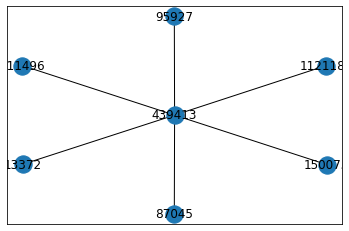

In [58]:
import networkx as nx

G_symmetric = nx.Graph()

for index, row in socialgraph[socialgraph['first_user_id']==439413].iterrows():
    G_symmetric.add_edge(row['first_user_id'],row['second_user_id'])

nx.spring_layout(G_symmetric)
nx.draw_networkx(G_symmetric)

## Problem 5.1: Draw path (with map) of week/month of users checkins.

###### It is strange that this being asked for top 10 users with most social instead of users with most checkins

In [59]:
import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## <span style="color:red">Which are the top 10 users has more checkins?</span>

In [60]:
sql = "select user_id, count(*) as x_times_checkin from checkins group by user_id order by count(*) desc"
users_checkins = pd.read_sql_query(sql, conn)
users_top_10_checkins = users_checkins.head(10).copy()
users_top_10_checkins

,user_id,x_times_checkin
0,1348362,57
1,1900906,52
2,1326476,48
3,1365850,47
4,386648,47
5,467043,46
6,651415,45
7,439413,45
8,304865,45
9,8622,45


### Use user with more checkins as sample

In [61]:
sample_user_id = 1326476
checkins_week_month = checkins.copy()
checkins_week_month['created_at'] = pd.to_datetime(checkins_week_month['created_at'])
checkins_week_month['week'] = checkins_week_month['created_at'].dt.week
checkins_week_month['month'] = checkins_week_month['created_at'].dt.month
sample_user_checkins = checkins_week_month[checkins_week_month['user_id']==sample_user_id]
sample_user_checkins.head(10)

,id,user_id,venue_id,latitude,longitude,created_at,week,month
19399,19415,1326476,61002,33.058106,-112.047642,2011-12-09 02:26:28,49,12
22919,22935,1326476,4432,33.058106,-112.047642,2011-12-09 04:45:24,49,12
190900,190916,1326476,11138,33.058106,-112.047642,2011-12-12 23:31:39,50,12
199607,199623,1326476,2964,33.058106,-112.047642,2011-12-13 04:25:57,50,12
302114,302130,1326476,1011459,33.058106,-112.047642,2011-12-24 12:29:01,51,12
312016,312032,1326476,68691,33.058106,-112.047642,2011-12-24 16:12:12,51,12
314680,314696,1326476,11138,33.058106,-112.047642,2011-12-24 19:08:44,51,12
340270,340286,1326476,28304,33.058106,-112.047642,2011-12-25 15:27:45,51,12
347842,347858,1326476,25610,33.058106,-112.047642,2011-12-25 19:56:54,51,12
376508,376524,1326476,4202,33.058106,-112.047642,2011-12-26 16:20:13,52,12


#### Provided data does not seems have valid checkin longitude and latitude. Get from Venues instead...

In [62]:
sample_user_checkins = sample_user_checkins.drop(['id','longitude', 'latitude'],axis=1)
sample_user_checkins = sample_user_checkins.merge(venues, left_on='venue_id', right_on='id', how='left')
sample_user_checkins = sample_user_checkins.drop(['id'],axis=1)
sample_user_checkins

,user_id,venue_id,created_at,week,month,latitude,longitude
0,1326476,61002,2011-12-09 02:26:28,49,12,38.693650,-121.590199
1,1326476,4432,2011-12-09 04:45:24,49,12,33.436527,-112.002182
2,1326476,11138,2011-12-12 23:31:39,50,12,39.848349,-104.674988
3,1326476,2964,2011-12-13 04:25:57,50,12,40.690596,-74.178100
4,1326476,1011459,2011-12-24 12:29:01,51,12,33.435484,-111.985859
5,1326476,68691,2011-12-24 16:12:12,51,12,29.653113,-95.276656
6,1326476,11138,2011-12-24 19:08:44,51,12,39.848349,-104.674988
7,1326476,28304,2011-12-25 15:27:45,51,12,41.787905,-87.740700
8,1326476,25610,2011-12-25 19:56:54,51,12,38.742402,-90.365896
9,1326476,4202,2011-12-26 16:20:13,52,12,30.202577,-97.667148


In [63]:
sample_user_checkins_week_4 = sample_user_checkins[sample_user_checkins['week']==4]
gdf = gpd.GeoDataFrame(sample_user_checkins_week_4, geometry=gpd.points_from_xy(sample_user_checkins_week_4.longitude, sample_user_checkins_week_4.latitude))
gdf

,user_id,venue_id,created_at,week,month,latitude,longitude,geometry
11,1326476,11492,2012-01-23 15:44:09,4,1,40.750476,-73.993607,POINT (-73.99361 40.75048)
12,1326476,2964,2012-01-23 16:48:18,4,1,40.690596,-74.178100,POINT (-74.17810 40.69060)
13,1326476,4432,2012-01-24 07:25:38,4,1,33.436527,-112.002182,POINT (-112.00218 33.43653)
14,1326476,4432,2012-01-25 22:51:14,4,1,33.436527,-112.002182,POINT (-112.00218 33.43653)
15,1326476,12004,2012-01-26 01:38:14,4,1,32.732346,-117.197299,POINT (-117.19730 32.73235)
16,1326476,5222,2012-01-26 03:41:42,4,1,37.616407,-122.386236,POINT (-122.38624 37.61641)
17,1326476,4432,2012-01-26 06:19:11,4,1,33.436527,-112.002182,POINT (-112.00218 33.43653)
18,1326476,4432,2012-01-27 16:39:08,4,1,33.436527,-112.002182,POINT (-112.00218 33.43653)


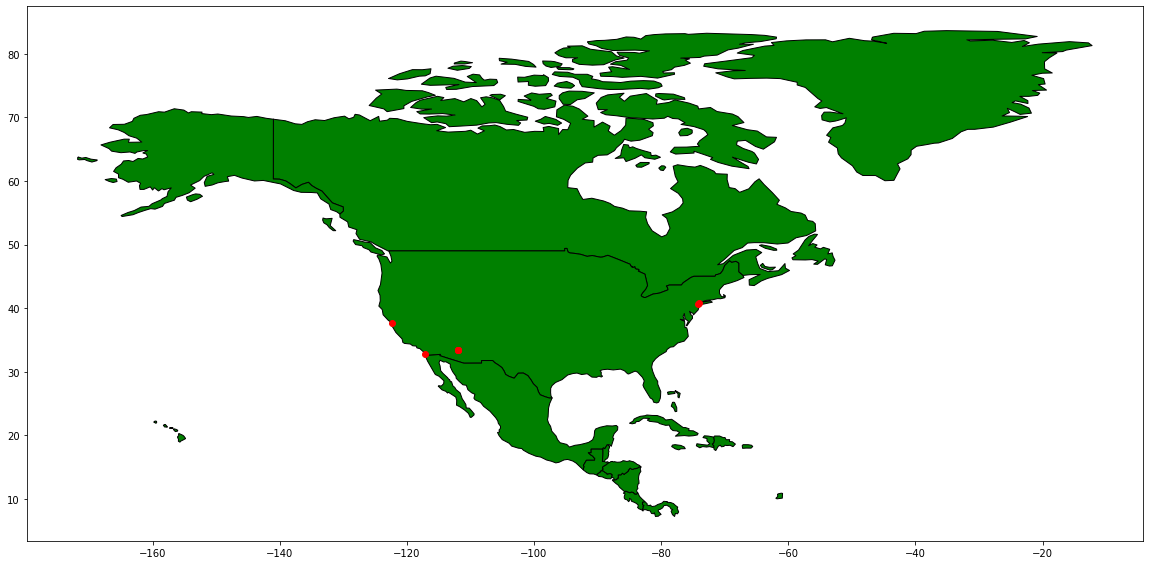

In [64]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(figsize=(20,15),color='green', edgecolor='black')
gdf.plot(ax=ax, color='red')

plt.show()

#### Plot all venues on world map

In [65]:
gdf = gpd.GeoDataFrame(venues, geometry=gpd.points_from_xy(venues.longitude, venues.latitude))

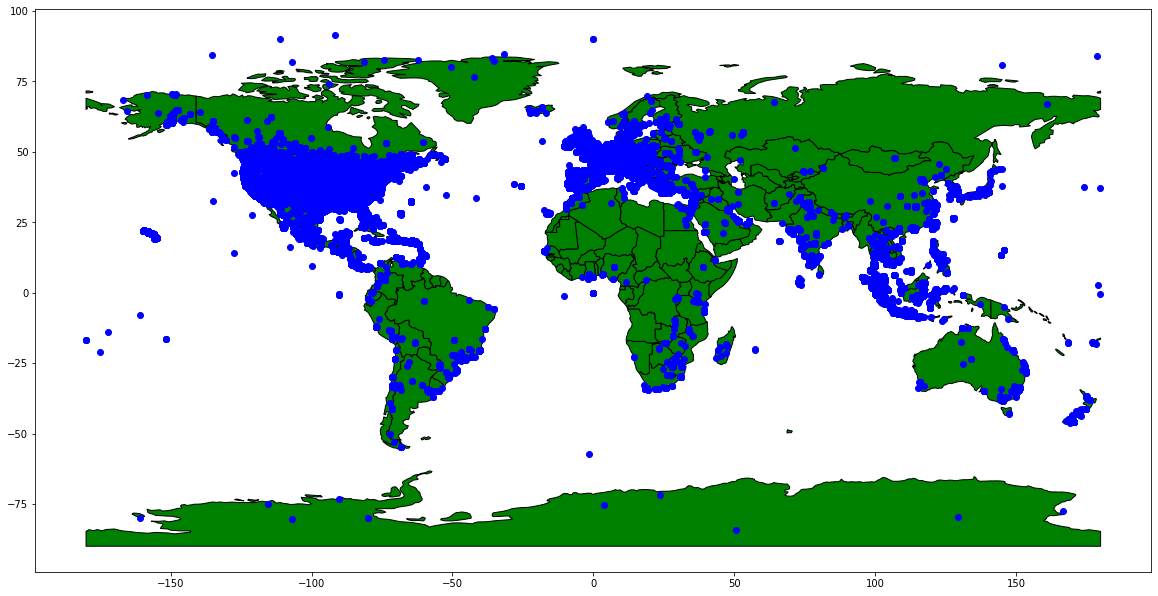

In [66]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,15),color='green', edgecolor='black')
gdf.plot(ax=ax, color='blue')

plt.show()

## Problem 5.2: List your friends and how close they are in terms of "taste" (based on venues visited and ranked)

In [67]:
# Users most social and has ever check in before
users_social_checkins = users_social.merge(users_checkins, left_on='first_user_id', right_on='user_id')
users_social_checkins = users_social_checkins[['user_id', 'x_friends', 'x_times_checkin']]
users_social_checkins

,user_id,x_friends,x_times_checkin
0,101,36532,2
1,3561,25062,2
2,48,19565,1
3,110131,14734,4
4,68741,14127,17
...,...,...,...
227413,10015,1,1
227414,9872,1,1
227415,4653,1,3
227416,4201,1,1


### Cluster ratings

In [68]:
venue_rating_by_user

,venue_id,user_id,rating
0,1,1,5.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,5.0
...,...,...,...
2436718,1142965,797976,2.0
2436719,1142966,1398671,2.0
2436720,1143011,83334,2.0
2436721,1143011,1626801,2.0


### Create variable "my_network" contains user and his friends user_id

In [69]:
user = 49857

In [70]:
friends = socialgraph[socialgraph['first_user_id']==user]['second_user_id'].unique()
friends

array([    47,     58, 148026,   4489,  19418,   9839, 855492, 406230,
           40, 855504,  10570, 672838, 855523, 855525, 855529, 822963,
       289412, 855538, 855540, 543445, 169657, 855574,  72121])

In [71]:
self = socialgraph[socialgraph['first_user_id']==user]['first_user_id'].unique()
self

array([49857])

In [72]:
my_network = np.concatenate((self, friends), axis=0)
my_network

array([ 49857,     47,     58, 148026,   4489,  19418,   9839, 855492,
       406230,     40, 855504,  10570, 672838, 855523, 855525, 855529,
       822963, 289412, 855538, 855540, 543445, 169657, 855574,  72121])

### Create variable "venue_rating_my_network" contains venue ratings in "my_network"

In [73]:
venue_rating_my_network = venue_rating_by_user[venue_rating_by_user['user_id'].isin(my_network)].copy()
venue_rating_my_network

,venue_id,user_id,rating
129230,190115,72121,5.0
285123,409649,19418,5.0
285124,409650,19418,5.0
285125,409651,19418,5.0
310480,445087,9839,5.0
...,...,...,...
1558438,409652,49857,2.5
1573139,64,10570,2.0
1709390,7284,9839,2.0
2178352,151331,9839,2.0


### Create variable "venue_rating_my_network_pivot" contains venue id as columns and rating as value

In [74]:
venue_rating_my_network_pivot = venue_rating_my_network.pivot(index='user_id', columns='venue_id', values='rating')

In [75]:
venue_rating_my_network_pivot = venue_rating_my_network_pivot.fillna(0)
venue_rating_my_network_pivot

venue_id,64,386,388,397,406,407,415,416,417,418,...,878870,878871,878872,878873,878874,878875,878876,878877,878878,878879
user_id,,,,,,,,,,,,,,,,,,,,,
40,0.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10570,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [76]:
labels = venue_rating_my_network_pivot.index.values
features = venue_rating_my_network_pivot.values.astype('int')

In [77]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

In [78]:
kmeans_model = KMeans(n_clusters=7, max_iter=10).fit(features)

In [79]:
print('Silhouette_score: ', metrics.silhouette_score(features, kmeans_model.labels_))

Silhouette_score:  0.2880649018757592


In [80]:
kmeans_model.labels_

array([3, 0, 6, 5, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1], dtype=int32)

In [81]:
centroids = kmeans_model.cluster_centers_
centroids

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.50000000e-01, 5.55111512e-17, 5.55111512e-17, ...,
        5.55111512e-17, 5.55111512e-17, 5.55111512e-17],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.00000000e+00, 4.00000000e+00, 4.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Show cluster centroids

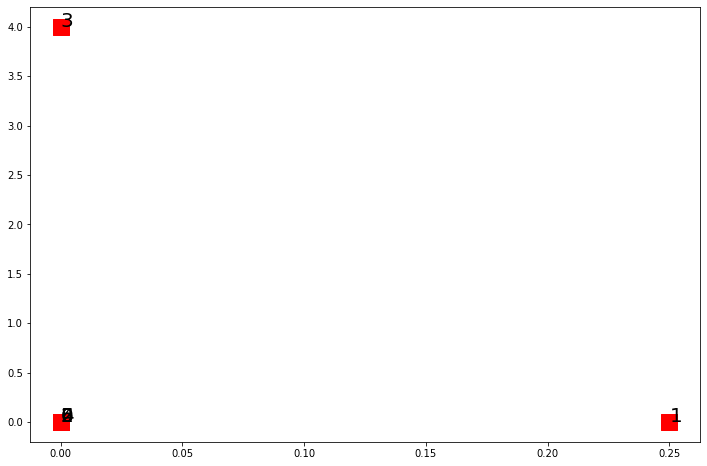

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(centroids[:,0], centroids[:,1], c='r', s=250, marker='s')

for i in range(len(centroids)):
    plt.annotate(i , (centroids[i][0], centroids[i][1]), fontsize=20)

In [83]:
category = pd.Series(kmeans_model.labels_)

In [84]:
user_ids = pd.Series(labels)

In [85]:
categorized = pd.DataFrame({'user_id': user_ids, 'category': category})
categorized

,user_id,category
0,40,3
1,47,0
2,58,6
3,4489,5
4,9839,1
5,10570,1
6,19418,1
7,49857,1
8,72121,2
9,148026,4


### Find out what category is this user

In [86]:
my_category = categorized[categorized['user_id']==user]
my_category = my_category['category'].values[0]
print('User ID:',user,'Category:',my_category)

User ID: 49857 Category: 1


### Find his friends belongs to same cluster category

In [87]:
my_category_cluster_filter = categorized[categorized['category']==my_category]['user_id']
my_category_cluster_filter

4       9839
5      10570
6      19418
7      49857
10    289412
11    672838
12    855523
13    855525
Name: user_id, dtype: int64

# Close database connection

In [88]:
conn.close()
print("Database closed successfully")

Database closed successfully
